In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
print len(storage.steps)
print len(storage.cvs)

1001
1


In [3]:
%%time
storage.samples.cache_all()
storage.samplesets.cache_all()
storage.pathmovechanges.cache_all()
storage.steps.cache_all()
map(lambda x : x.cache_all(storage), storage.cvs)

CPU times: user 2.26 s, sys: 425 ms, total: 2.68 s
Wall time: 2.61 s


In [4]:
retis = storage.transitions.load(0)
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [5]:
%%prun
print retis.rate(storage)

1.40651622364e-05
 

In [6]:
%%time
print retis.conditional_transition_probability(storage, retis.ensembles[-1])

0.65034965035
CPU times: user 41.6 ms, sys: 13 ms, total: 54.5 ms
Wall time: 45.2 ms


In [7]:
%%prun
retis.all_statistics(storage, force=True)

In [8]:
%%prun
print retis.total_crossing_probability(storage=storage)

In [9]:
%%prun
print retis.minus_move_flux(storage=storage)

0.00235439900867
 

In [10]:
%%time
retis.move_summary(storage)

pathreversal ran 22.7772227772% of the cycles with acceptance 188/228 (0.824561403509) 
shooting ran 50.2497502498% of the cycles with acceptance 371/503 (0.737574552684) 
minus ran 1.8981018981% of the cycles with acceptance 19/19 (1.0) 
repex ran 24.975024975% of the cycles with acceptance 82/250 (0.328) 
CPU times: user 163 ms, sys: 30.4 ms, total: 193 ms
Wall time: 171 ms


In [13]:
retis.move_summary(storage, 'shooting')

OneWayShootingMover I'face 0 ran 8.19180819181% of the cycles with acceptance 68/82 (0.829268292683) 
OneWayShootingMover I'face 3 ran 8.69130869131% of the cycles with acceptance 61/87 (0.701149425287) 
OneWayShootingMover I'face 1 ran 7.89210789211% of the cycles with acceptance 64/79 (0.810126582278) 
OneWayShootingMover I'face 4 ran 8.59140859141% of the cycles with acceptance 59/86 (0.686046511628) 
OneWayShootingMover I'face 2 ran 9.29070929071% of the cycles with acceptance 69/93 (0.741935483871) 
OneWayShootingMover I'face 5 ran 7.59240759241% of the cycles with acceptance 50/76 (0.657894736842) 


In [14]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [15]:
first40 = first_n(storage, 40, trajid=4)

In [16]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 2.5 s, sys: 395 ms, total: 2.89 s
Wall time: 2.92 s


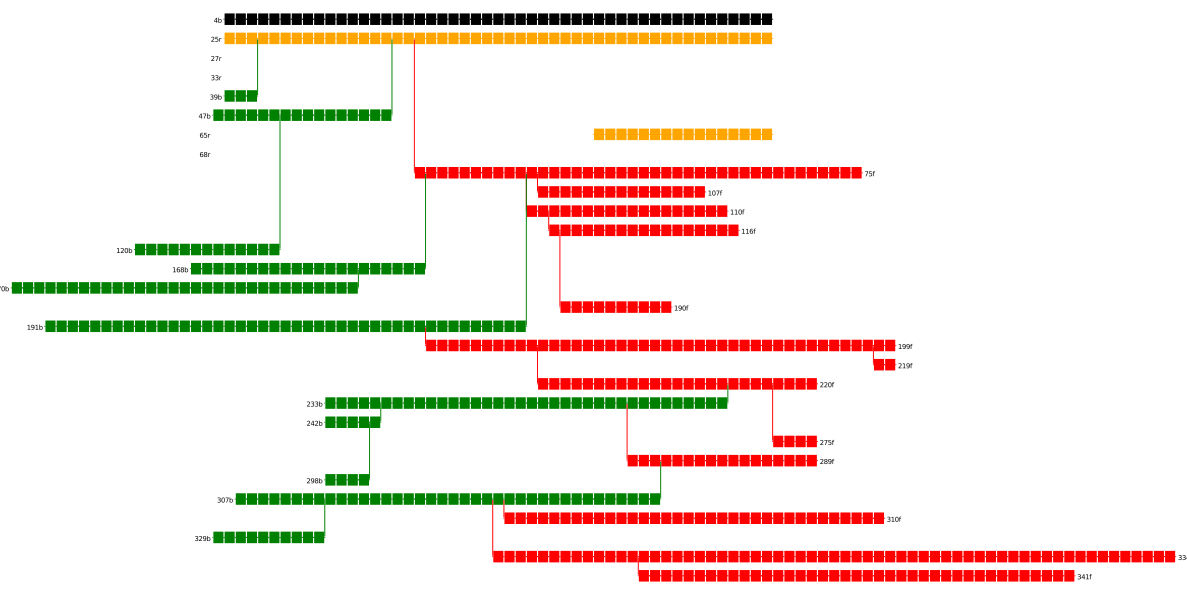

In [17]:
SVG(view.to_svg())

In [18]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 4 decorrelated trajectories.


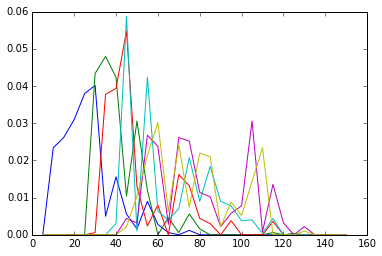

In [20]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

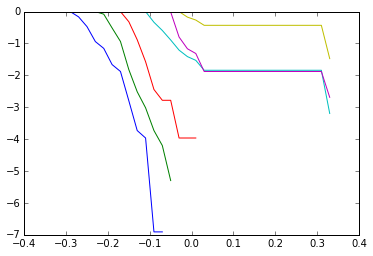

In [21]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

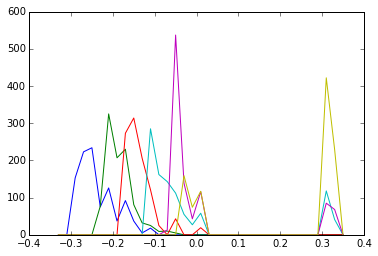

In [22]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

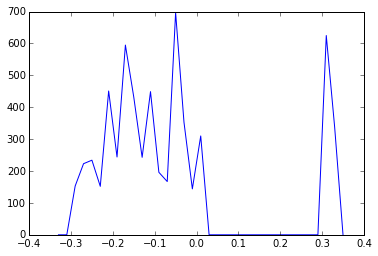

In [23]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [24]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

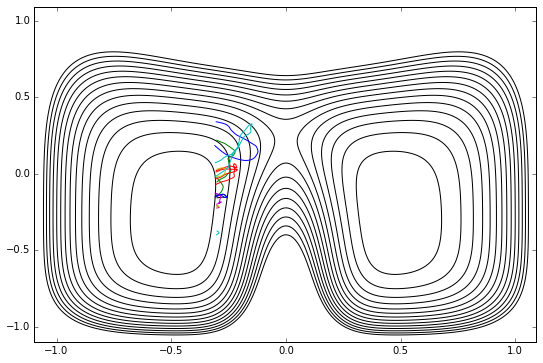

In [25]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

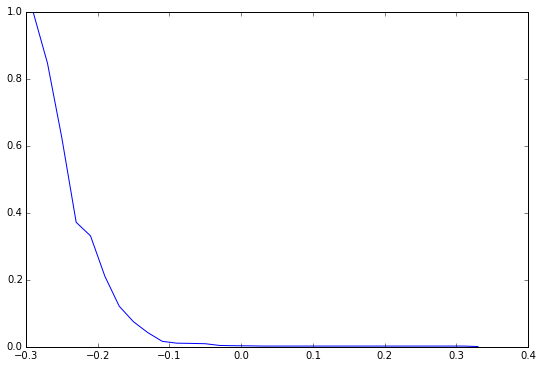

In [26]:
plt.plot(retis.tcp.keys(), retis.tcp.values());

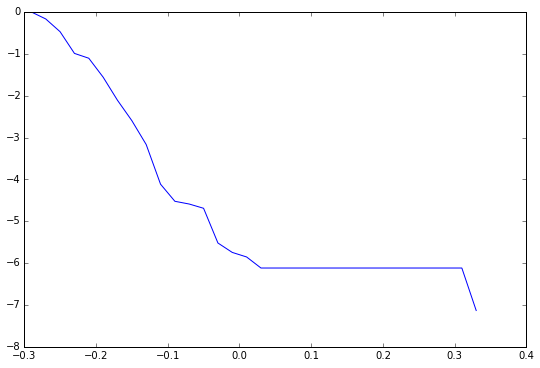

In [27]:
plt.plot(retis.tcp.keys(), np.log(retis.tcp.values()));

In [28]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 41.2 ms, sys: 13.1 ms, total: 54.3 ms
Wall time: 44.9 ms


0.6503496503496503

In [29]:
retis.minus_move_flux(storage)

0.0023543990086741019

In [30]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.00235439900867 0.00918581656618 0.65034965035


In [31]:
outer_ens = retis.ensembles[-1]

outer_cross_prob = retis.histograms['max_lambda'][outer_ens]
lambda_bin = -1
while (outer_cross_prob.reverse_cumulative()[lambda_bin+1] == 1.0):
    lambda_bin += 1

outer_cross_lambda = outer_cross_prob.bins[lambda_bin]

In [32]:
retis.rate(storage)

1.4065162236407329e-05

In [33]:
print retis._flux * retis.tcp(-0.05) * retis.ctp[retis.ensembles[-1]]

1.40651622364e-05
